# Обучение модели классификации комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

ТЗ: Обучите модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

**Условие:**
Постройте модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# база
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#
#лематизация для англоязычного текста
#import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
#регулярные выражения
import re
# разбивка на выборки
from sklearn.model_selection import train_test_split
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 
#Модели
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
#Метрика
from sklearn.metrics import f1_score
#
import time
from tqdm import tqdm
# Grid+Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
try:
    data = pd.read_csv(r'C:\Users\Admin\Downloads\toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

display(data.head())
display(data.info())
display(data.sample(5))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
103540,Becouse no one gives a SHIT...,1
48009,I've started a new page for structured mediati...,0
65361,I've replaced the pic because the results seem...,0
81297,REDIRECT Talk:Hickleton and Thurnscoe Halt rai...,0
112313,it's me. \n\ntrust me. why would i pretend to ...,0


In [3]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

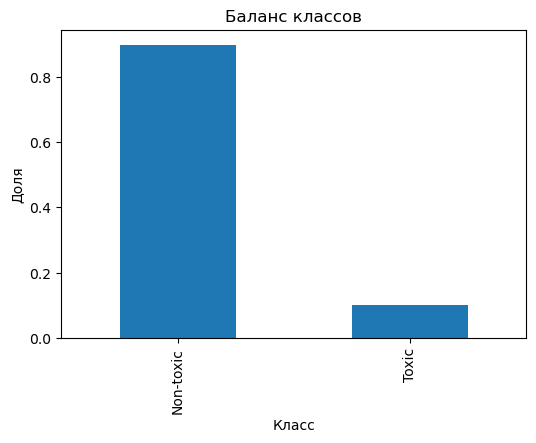

In [4]:
plt.figure(figsize=(6, 4))
data['toxic'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.title('Баланс классов')
plt.xticks([0, 1], ['Non-toxic', 'Toxic'])
plt.show()

Видим, что предоставленный текс с датасеста на английском языке, воспользуемся  WordNet Lemmatizer.


**Краткая сводка:** 

    - В датасете 159292 строки
    - Целевой признак в столбце 'toxiс'
    - Данные датасета на английском языке.
    - Сильный дисбаланс классов. 

In [5]:
nltk.download('omw-1.4')
nltk.download('wordnet')  # загрузка компонентов WordNet
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

In [6]:
# Функция для определения Pos-тега WordNet
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
# Загрузка Pos-тегов и лемматизация столбца 'text'
start_time = time.time()
tqdm.pandas()
data['clean_text'] = (data['text'].progress_apply
                      (lambda x:' '.join([lemmatizer.lemmatize(token, get_wordnet_pos(tag)) 
                                           for token, tag in pos_tag(x.split()) if get_wordnet_pos(tag) is not None])))
end_time = time.time()
execution_time = end_time - start_time
print("Время выполнения кода:", execution_time, "секунд")

In [8]:
data['clean_text'].head(10)

In [10]:
data['clean_text']=data['clean_text'].str.lower()
data.head(10)

In [11]:
def clear_text(text):
    cl_text = re.sub(r'[^a-zA-Z]',' ', text)
    cl_text= " ".join(cl_text.split())
    return cl_text

In [12]:
data['clean_text'] = data['clean_text'].apply(clear_text)
data.head()

Текст лемматизировали, привели к нижнему регистру, убрали лишние символы, и всю эту красоту положили в новую колонку clean_text.

## Обучение

In [13]:
#Разбиваем на выборки
features = data['clean_text']
target = data['toxic']

In [14]:
features.shape

In [15]:
target.shape

In [16]:

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345, stratify=target)

In [17]:
display(x_train.shape)
display(x_test.shape)

In [20]:


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('logreg', LogisticRegression(class_weight='balanced', random_state=12345))
])

# GridSearchCV
parameters = {
     'logreg__max_iter': [500]

}

grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='f1')
grid_search.fit(x_train, y_train)
param_log = grid_search.best_params_
f1_log = grid_search.best_score_


print('Лучшие параметры:',param_log)
print('F1', f1_log)


In [22]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('lgbm', LGBMClassifier(class_weight='balanced', random_state=12345)),
])

parameters = { 
    'lgbm__n_estimators': [1000], 
    'lgbm__max_depth': [8,16],
    'lgbm__num_leaves': [8,16]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1' )
grid_search.fit(x_train, y_train)

best_model_lgbm = grid_search.best_estimator_
best_params_lgbm = grid_search.best_params_
best_f1_lgbm = grid_search.best_score_


print('Лучшая модель:', best_model_lgbm)
print('F1:', best_f1_lgbm)
print('Лучшие параметры:', best_params_lgbm)


In [27]:

pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', ngram_range=(1, 2)),
    CatBoostClassifier(class_weights=[0.1, 0.9], verbose=5, random_state=12345)
)
parameters = {
    'catboostclassifier__iterations': [10,20],
    'catboostclassifier__depth': [6,10]
}    
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='f1')
grid_search.fit(x_train, y_train)

best_model_cat = grid_search.best_estimator_
best_params_cat = grid_search.best_params_
best_f1_cat = grid_search.best_score_


print('Лучшая модель:', best_model_cat)
print('F1:', best_f1_cat)
print('Лучшие параметры:', best_params_cat)

In [30]:
# Выбор лучшей на основе валидации
table = {'Модели':
    ['Логистическая регрессия', 'LGBM', 'CatBoost'],
         'Параметры': [param_log, best_params_lgbm, best_params_cat ],
         'RMSE valid':[f1_log, best_f1_lgbm, best_f1_cat]
         
}

table = pd.DataFrame(table)
table.head()

Лучшая модель по метрике F1 - LGBM, ее и возьем на тестирование. 

In [32]:

# LGBM тест
pipeline = Pipeline([ #тут я понял, как здорово различать переменные, а не перезаписывать их, вместо обращение делается дублирование
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('lgbm', LGBMClassifier(class_weight='balanced'), random_state=12345),
])
parameters = { # обучается целую вечность, я бы рад ставить больше, но ждать будем неделями
    'lgbm__n_estimators': [1000], 
    'lgbm__max_depth': [16],
    'lgbm__num_leaves': [16]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5)
grid_search.fit(x_train, y_train)

y_pred = grid_search.predict(x_test)
print('F1:',f1_score(y_test, y_pred))


Отлично! Метрика F1 на тестовых данных оказалось оптимальной для заказчика (0.75)

## Выводы

- Загрузили и изучили данные:

    - Датасет на 159,292 строки. 
    - Целевой признак в столбце 'toxiс'
    - Данные датасета на английском языке.
- Подготовили функцию для определения Pos-тегов
- Подгрузили POS-теги и лемматизировали столбец 'text', преобразованые данные добавили в новый столбец датасета 'clean_text'
- Привели обработанный текст к нижнему регистру
- Почистили текста от лишних символов
- Разбили датасет на 3 набора данных: обучающий, валидационный и тестовый
- Произвели TF-IDF векторизацию выборок
- Обучили модели логистической классификачии, LGBM и CatBoost
- Получили метрику F1 на предсказании валидационных данных
- Сделали таблицу сравнения метрик F1, для выбора лучшей модели и проверки ее на тестовых данных. 
- Лучшая модель по метрике F1 LGBM
- На тестовых данных LGBM показала метрику F1 - 0.755